# Практическое задание №4. CNN

Обучите CNN (самописная) на CIFAR-100.
Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

## Импорт библиотек

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
# from tqdm import tqdm

from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tqdm'

## Определение и загрузка датасета

In [ ]:
dataset = datasets.CIFAR10(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

30.8%


## Определение трансформации

In [ ]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])


## Разделение на выборки

In [ ]:

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

## Определение загрузчиков

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128,
                                               shuffle=True,
                                               num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

## Метки классов

In [ ]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog',
           'frog', 'horse', 'ship', 'truck']

## Проверка загрузчика

torch.Size([128, 3, 32, 32])
ship


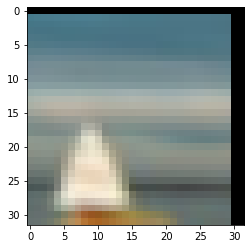

In [ ]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

## Определение среды исполнения

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Определение NN

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 10)

    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


## Определение оптимизатора и функции потерь

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Ревизия сети

In [ ]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                   [-1, 10]             610
Total params: 191,316
Trainable params: 191,316
Non-trainable params: 0
-------------------------------

## Функция обучения

In [ ]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        net.train()

print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.018. Acc: 0.086. Test acc: 0.101
Epoch [1/5]. Step [301/372]. Loss: 0.015. Acc: 0.275. Test acc: 0.350
Epoch [2/5]. Step [1/372]. Loss: 0.014. Acc: 0.406. Test acc: 0.360
Epoch [2/5]. Step [301/372]. Loss: 0.013. Acc: 0.403. Test acc: 0.485
Epoch [3/5]. Step [1/372]. Loss: 0.012. Acc: 0.430. Test acc: 0.475
Epoch [3/5]. Step [301/372]. Loss: 0.012. Acc: 0.450. Test acc: 0.534
Epoch [4/5]. Step [1/372]. Loss: 0.011. Acc: 0.508. Test acc: 0.475
Epoch [4/5]. Step [301/372]. Loss: 0.011. Acc: 0.475. Test acc: 0.550
Epoch [5/5]. Step [1/372]. Loss: 0.011. Acc: 0.477. Test acc: 0.533
Epoch [5/5]. Step [301/372]. Loss: 0.011. Acc: 0.497. Test acc: 0.536
Training is finished!
